# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below.

![graphcut](graphcut.png)

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [6]:
import sys
import os
import numpy as np
import math
import cv2 
import igraph as ig
from sklearn.cluster import KMeans
import time
import matplotlib.pyplot as plt 
from sklearn.mixture import GaussianMixture
import os
import matplotlib
import statistics 

In [7]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)


In [8]:
def find_beta(img ,connection):
    total = np.array([0,0,0],dtype='float64')

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):

            if j>0: ## Left 
                total += (img[i,j] - img[i,j-1])**2

            if i>0 and j>0 and connection==8: ## Upper Left 
                total += (img[i][j] - img[i-1][j-1])**2

            if i>0: ## Up
                total += (img[i][j] - img[i-1][j])**2

            if i>0 and j<img.shape[1]-1 and connection == 8: ## Upper Right 
                total += (img[i][j] - img[i-1][j+1])**2

    return total.sum() 

def find_median_beta(img):
    med = []
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            if j>0:
                med.append(np.sum(np.square(img[i][j] - img[i][j-1])))
            
            if i>0 and j>0:
                med.append(np.sum(np.square(img[i][j] - img[i-1][j-1])))
            
            if i>0:
                med.append(np.sum(np.square(img[i][j] - img[i-1][j])))
            
            if i>0 and j<img.shape[1]-1:
                med.append(np.sum(np.square(img[i][j] - img[i-1][j+1])))
    
    
    return statistics.median(med) 


def find_mode_beta(img):
    med = []
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            if j>0:
                med.append(np.sum(np.square(img[i][j] - img[i][j-1])))
            
            if i>0 and j>0:
                med.append(np.sum(np.square(img[i][j] - img[i-1][j-1])))
            
            if i>0:
                med.append(np.sum(np.square(img[i][j] - img[i-1][j])))
            
            if i>0 and j<img.shape[1]-1:
                med.append(np.sum(np.square(img[i][j] - img[i-1][j+1])))
    
    
    return statistics.mode(med) 
        

def find_Vterm(gamma ,img ,beta):
    left = []
    uleft = []
    up = []
    uright = []

    for i in range(img.shape[0]):
        temp_left = []
        temp_uleft = []
        temp_up = []
        temp_uright = []

        for j in range(img.shape[1]):  
            if j>0:
                temp_left.append( img[i,j] - img[i,j-1])

            if i>0 and j>0:
                temp_uleft.append( img[i,j] - img[i-1,j-1] )

            if i>0:
                temp_up.append(img[i,j] - img[i-1,j])

            if i>0 and j<img.shape[1]-1:
                temp_uright.append(img[i,j] - img[i-1,j+1])

        left.append(temp_left)

        if len(temp_uleft)> 0 :
            uleft.append(temp_uleft)

        if len(temp_up)>0:
            up.append(temp_up)

        if len(temp_uright)>0:
            uright.append(temp_uright)

    left = np.array(left ,dtype='float64')
    uleft = np.array(uleft,dtype='float64')
    up = np.array(up,dtype='float64')
    uright = np.array(uright,dtype='float64')

    return left ,uleft ,up ,uright


def apply_Vscore(arr ,beta , gamma ):
    temp = np.square(arr)
    temp = np.sum( temp ,axis =2)
    temp = -beta*temp
    temp = np.exp(temp)

    return gamma*temp



def find_idx(arr,v1 ,v2):
    x = []
    y = []

    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):

            if arr[i,j] == v1 or arr[i,j] == v2:
                x.append(i)
                y.append(j)

    idx = tuple([ np.array(x) ,np.array(y) ])

    return idx 


def det_of_cov(clf ,k):
    det_cov = []

    for i in range(k):
        cov = clf.covariances_[i]
        det = np.linalg.det(cov)
        log = (1/2)*np.log(det)

        det_cov.append(log)

    return det_cov

def get_inv_cov(clf , k):
    inv_cov = [] 

    for i in range(k):
        inv = np.linalg.inv(clf.covariances_[i])
        inv_cov.append(inv)

    return inv_cov

def get_means(clf , k):
    means = []

    for i in range(k):
        means.append(clf.means_[i])

    return means

def get_coefs(clf ,k):
    coefs = []

    for i in range(k):
        w = clf.weights_[i]
        log = -np.log(w)
        coefs.append(log)

    return coefs

def calc_Dterm(comp ,pixel ,means ,det_cov ,inv_covs ,wt ):
    t1 = det_cov[comp]

    t2 = np.transpose(pixel - means[comp])
    t2 = np.dot(t2, inv_covs[comp])
    t2 = np.dot(t2 , (pixel - means[comp]))

    t3 = wt[comp]

    return t1+t2+t3


def get_1d_idx(arr ,v1 ,v2=None):
    idx = []

    if v2!=None:

        for i in range(len(arr)):
            if arr[i]==v1 or arr[i]==v2:
                idx.append(i)
    else:

        for i in range(len(arr)):
            if arr[i] ==v1:
                idx.append(i)

    idx = np.array(idx)
    idx = tuple([idx])

    return idx

def gen_edges(node ,pix_idx ,edges):

    for i in pix_idx:
        edges.append( tuple([node , i]))

    return edges

def pix_edges( arr):

    left = []
    up_left = []
    up = []
    up_right = []

    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):

            if j>0:
                left.append( tuple([arr[i,j] , arr[i,j-1]]) )

            if i>0 and j>0:
                up_left.append( tuple([arr[i,j] , arr[i-1,j-1]]))

            if i>0:
                up.append( tuple([arr[i,j],arr[i-1,j]]))

            if i>0 and j<arr.shape[1]-1:
                up_right.append( tuple([arr[i,j] ,arr[i-1 ,j+1]]))

    return left , up_left ,up ,up_right

def make_mask(bool_mask ,v1 ,v2 ):
    op_mask = []
    for idx in range( len(bool_mask)):

        if bool_mask[idx] == True:
            op_mask.append(v1)
        else:
            op_mask.append(v2)

    return np.array(op_mask)

In [9]:

class GrabC:
    
    def __init__(self, img, k ,connection):
        self.k = k # The number of components in each GMM model
        
        self.connection = connection
        
        self.img = np.asarray(img, dtype = np.float32)
        self.img_copy = img.copy()
        self.rows, self.cols = img.shape[0] ,img.shape[1]
        self.gamma = 50
        self.beta = 0
        
        self.BG = 0
        self.FG = 1
        self.P_BG = 2
        self.P_FG = 3
        
        self._mask = np.zeros([self.rows, self.cols], dtype = np.uint8) 
        
        self.gc_source = self.cols*self.rows
        self.gc_sink = self.gc_source + 1

        self.calc_beta()
        self.calc_V()
    
    def calc_beta(self):
        beta = 0
        
        if self.connection == 8:
#             beta = find_beta(self.img ,self.connection)
#             self.beta = 1/(2*beta/(4*self.cols*self.rows - 3*self.cols - 3*self.rows + 2))
            #self.beta = find_median_beta(self.img)
            self.beta = find_mode_beta(self.img)
        else:
            beta = find_beta(self.img ,self.connection)
            self.beta = 1/(2.0*beta / (2 * self.rows * self.cols - self.rows - self.cols + 2.0))
        
        #self.beta = 0
        
    def calc_V(self): 
        
        left , uleft ,up ,uright = find_Vterm(self.gamma , self.img , self.beta)
    
        self.leftV = apply_Vscore(left , self.beta ,self.gamma )
        self.upleftV = apply_Vscore(uleft , self.beta ,self.gamma )
        self.upV = apply_Vscore(up , self.beta ,self.gamma )
        self.uprightV = apply_Vscore(uright , self.beta ,self.gamma )

    
    def GMM_init(self):
               
        self._bgd = find_idx(self._mask ,self.BG , self.P_BG)
        self._fgd = find_idx(self._mask ,self.FG , self.P_FG)

        self._BGDpixels = self.img[self._bgd]
        self._FGDpixels = self.img[self._fgd]
            
        self.BGD_GMM = GaussianMixture(n_components = self.k, covariance_type='full')
        self.FGD_GMM = GaussianMixture(n_components = self.k, covariance_type='full')
        
        self.BGD_GMM.fit(self._BGDpixels)
        self.FGD_GMM.fit(self._FGDpixels)

        
    def D_term(self, img ,clf):
        pix = img.reshape(img.shape[0]*img.shape[1],img.shape[2])
        componants = clf.predict(pix)
        
        det_cov = det_of_cov(clf , self.k)
        inv_covs = get_inv_cov(clf , self.k)
        means = get_means(clf , self.k)
        wt = get_coefs(clf,self.k)
        
        d_list = []
        for i in range(len(componants)):
            comp = componants[i]            
            d_val = calc_Dterm(comp ,pix[i] ,means ,det_cov ,inv_covs ,wt)
            d_list.append(d_val)

        d_list = np.array(d_list).reshape(img.shape[0],img.shape[1])
        return d_list

        
    def build_graph(self):      
        mask_1d = self._mask.reshape(-1)
        bgd_indexes = get_1d_idx( mask_1d ,self.BG)
        fgd_indexes = get_1d_idx( mask_1d ,self.FG)
        pr_indexes = get_1d_idx( mask_1d ,self.P_BG ,self.P_FG)
        
        edges = []
        self.graph_capacity = []
        
        ### Adding Sink ,Source Nodes
        edges = gen_edges(self.gc_source , pr_indexes[0] ,edges )
        bg_pen = self.bg_penalty.reshape(-1)
        bg_pen = bg_pen[pr_indexes]
        self.graph_capacity.extend(bg_pen.tolist())
        
        edges = gen_edges(self.gc_sink , pr_indexes[0] ,edges )
        fg_pen = self.fg_penalty.reshape(-1)
        fg_pen = fg_pen[pr_indexes]
        self.graph_capacity.extend(fg_pen.tolist())

        
        edges = gen_edges(self.gc_source , bgd_indexes[0] ,edges )
        self.graph_capacity.extend([0] * bgd_indexes[0].size)
        
        edges = gen_edges(self.gc_sink , bgd_indexes[0] ,edges )
        self.graph_capacity.extend([9 * self.gamma] * bgd_indexes[0].size)
        
        edges = gen_edges(self.gc_source , fgd_indexes[0] ,edges )
        self.graph_capacity.extend([9 * self.gamma] * fgd_indexes[0].size)
        
        edges = gen_edges(self.gc_sink , fgd_indexes[0] ,edges )
        self.graph_capacity.extend([0] * fgd_indexes[0].size)

        ### Adding pixel nodes 
 
        img_indexes = np.arange(self.rows*self.cols,dtype=np.uint32).reshape(self.rows,self.cols)
        left , up_left , up ,up_right = pix_edges(img_indexes)
        
        edges.extend(left)
        self.graph_capacity.extend(self.leftV.reshape(-1).tolist())
        
        edges.extend(up)
        self.graph_capacity.extend(self.upV.reshape(-1).tolist())
        
        if self.connection == 8 :
            edges.extend(up_left)
            self.graph_capacity.extend(self.upleftV.reshape(-1).tolist())

            edges.extend(up_right)    
            self.graph_capacity.extend(self.uprightV.reshape(-1).tolist())
        
        self.graph = ig.Graph(self.cols * self.rows + 2)
        self.graph.add_edges(edges)
        
        
    def segment(self):
        mincut = self.graph.st_mincut(self.gc_source,self.gc_sink, self.graph_capacity)
        
        #print('mincut')
        pr_indexes = find_idx(self._mask ,self.P_BG ,self.P_FG)
    
        img_indexes = np.arange(self.rows * self.cols,dtype=np.uint32).reshape(self.rows, self.cols)
        
        bool_mask = np.isin(img_indexes[pr_indexes], mincut.partition[0])
        
        self._mask[pr_indexes] = make_mask(bool_mask ,self.P_FG, self.P_BG)
       
    
    def calc_energy(self):
        u_term = self.bg_penalty.sum() + self.fg_penalty.sum()
        
        v_term = 0
        
        for i in range(self.img.shape[0]):
            for j in range(self.img.shape[1]):
                
                if j>0 and self._mask[i,j] == self._mask[i,j-1]:
                    v_term += np.exp( -self.beta * np.sum(np.square( self._mask[i,j] - self._mask[i,j-1]) ))
                
                if j>0 and i>0 and self._mask[i,j] == self._mask[i-1,j-1]:
                    v_term += np.exp( -self.beta * np.sum(np.square( self._mask[i,j] - self._mask[i-1,j-1]) ))
                
                if i>0 and self._mask[i,j] == self._mask[i-1,j]:
                    v_term += np.exp( -self.beta * np.sum(np.square( self._mask[i,j] - self._mask[i-1,j]) ))
                
                if i>0 and j<self._mask.shape[1]-1 and self._mask[i,j] == self._mask[i,j-1]:
                    v_term += np.exp( -self.beta * np.sum(np.square( self._mask[i,j] - self._mask[i-1,j+1]) ))
        
        return (u_term + self.gamma*v_term)
    
                
    def run(self ,n ,mask=None ,rect=None ,ismask =False):
        
        energy = []
        if ismask==False:
            self._mask[rect[1]+3:rect[1]+rect[3]-3, rect[0]+3:rect[0]+rect[2]-3] = self.P_FG
            print('Init GMM')
            self.GMM_init()
        else:
            self._mask = mask
        
        for i in range(n):
            print('Calculating Probablities : ')
            self.fg_penalty = self.D_term(self.img, self.FGD_GMM)
            self.bg_penalty = self.D_term(self.img, self.BGD_GMM)
            
            print('Construct Graph')
            self.build_graph()
            
            print('Estimate Seg')
            self.segment() 
            
            
            FGD = np.where((self._mask == 1) + (self._mask == 3), 255, 0).astype('uint8')
            output = cv2.bitwise_and(self.img, self.img, mask = FGD)
            
            cv2.imwrite(str(i)+'.jpg' ,output )
            
        return energy            

In [10]:
def run(filename ):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8)  
    output = np.zeros(img.shape, np.uint8)           

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    
    GC = GrabC(img, k = 5 ,connection = 8)
    
    energy = None 
    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        if k == 27:
            break
        
        elif k == ord('0'): 
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            FLAGS['value'] = DRAW_FG
                
        elif k == 13: 
            if FLAGS['rect_or_mask'] == 0:
                energy = GC.run(1 ,mask ,FLAGS['RECT'] ,False )
                FLAGS['rect_or_mask'] = 1
            elif FLAGS['rect_or_mask'] == 1:
                energy = GC.run(1 ,mask , None , True)
        
            EventObj.flags = FLAGS
            FGD = np.where((GC._mask == 1) + (GC._mask == 3), 255, 0).astype('uint8')
            output = cv2.bitwise_and(GC.img_copy, GC.img_copy, mask = FGD)
            EventObj.mask = GC._mask
    
    return energy

In [12]:
if __name__ == '__main__':
    filename = '../images/banana1.jpg'
    run(filename)
    cv2.destroyAllWindows()

In [17]:
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

def plot(img1 ,img2):
    img1 = cv2.cvtColor( cv2.imread(img1) , cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(img2) ,cv2.COLOR_BGR2RGB )

    pix , a = plt.subplots(1,2)

    a[0].imshow(img1)
    a[0].set_title('Image')

    a[1].imshow(img2)
    a[1].set_title('Segmented Image')
    print()

## Results ( With 1 Iteration)

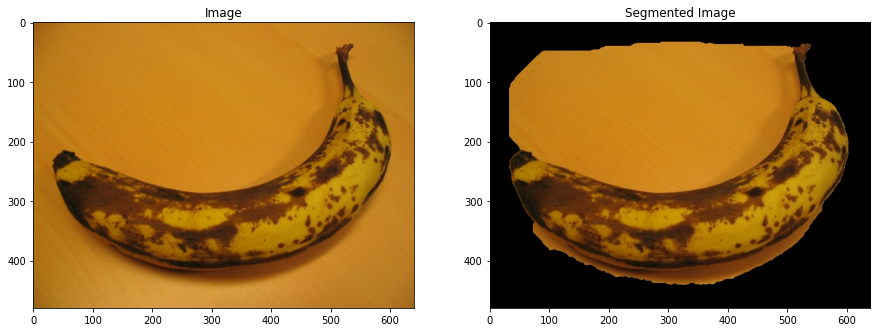

In [14]:
plot('../images/banana1.jpg' ,'../output_img/banana1.jpg')

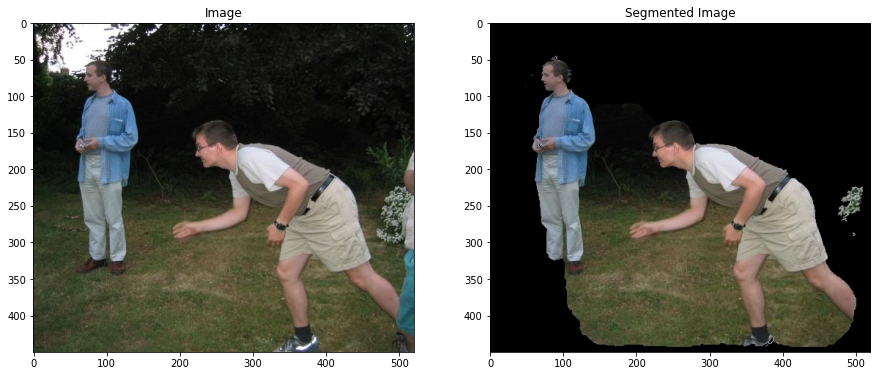

In [15]:
plot('../images/bool.jpg' ,'../output_img/bool.jpg')

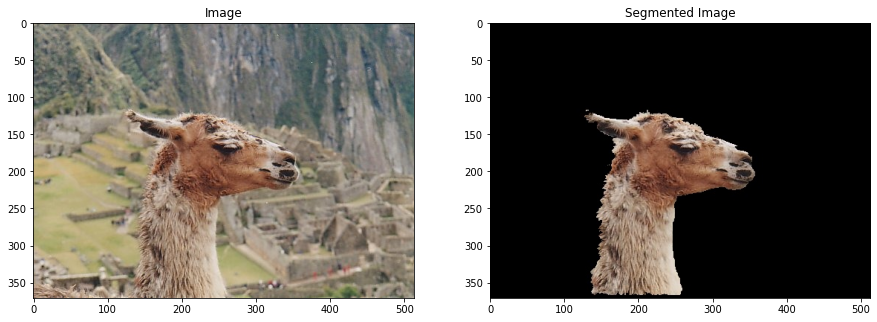

In [16]:
plot('../images/llama.jpg' ,'../output_img/llama.jpg')

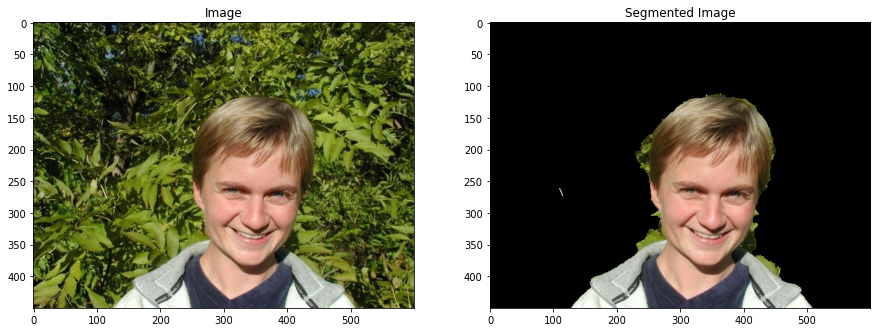

In [17]:
plot('../images/person2.jpg' ,'../output_img/person2.jpg')

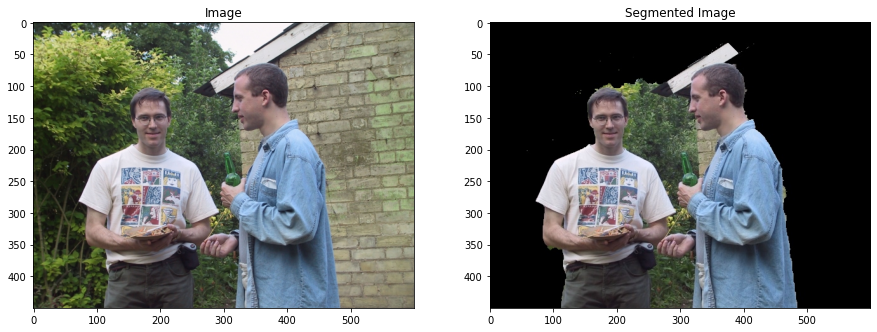

In [18]:
plot('../images/person4.jpg' ,'../output_img/person4.jpg')

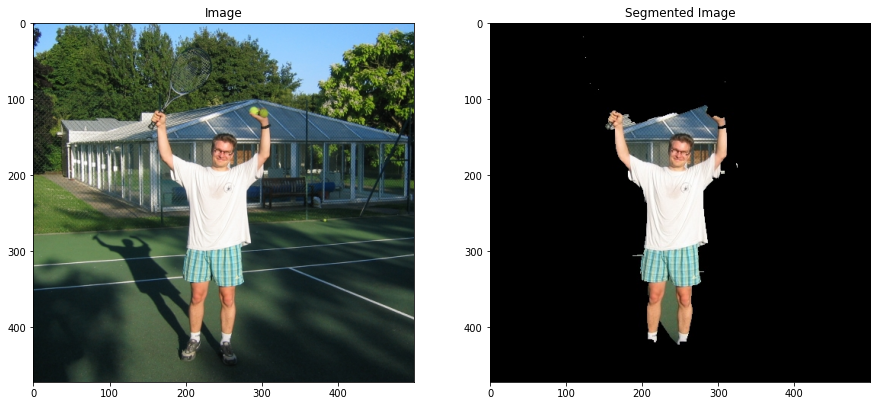

In [19]:
plot('../images/tennis.jpg' ,'../output_img/tennis.jpg')

## 1) Number of GMM Componants 

In [11]:
run('../images/llama.jpg')
cv2.destroyAllWindows()

In [14]:
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

def plot_k(para):
    if para == 'b':
        img1 = cv2.cvtColor( cv2.imread('2_banana.jpg') , cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread('10_banana.jpg') ,cv2.COLOR_BGR2RGB )
        img3 = cv2.cvtColor(cv2.imread('15_banana.jpg') ,cv2.COLOR_BGR2RGB )
        img4 = cv2.cvtColor(cv2.imread('20_banana.jpg') ,cv2.COLOR_BGR2RGB )
    else:
        img1 = cv2.cvtColor( cv2.imread('2_llama.jpg') , cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread('10_llama.jpg') ,cv2.COLOR_BGR2RGB )
        img3 = cv2.cvtColor(cv2.imread('15_llama.jpg') ,cv2.COLOR_BGR2RGB )
        img4 = cv2.cvtColor(cv2.imread('20_llama.jpg') ,cv2.COLOR_BGR2RGB )
        
    pix , a = plt.subplots(1,4)

    a[0].imshow(img1)
    a[0].set_title('K = 2')

    a[1].imshow(img2)
    a[1].set_title('K = 10')
    
    a[2].imshow(img3)
    a[2].set_title('K = 15')
    
    a[3].imshow(img4)
    a[3].set_title('K = 20')
    
    print()

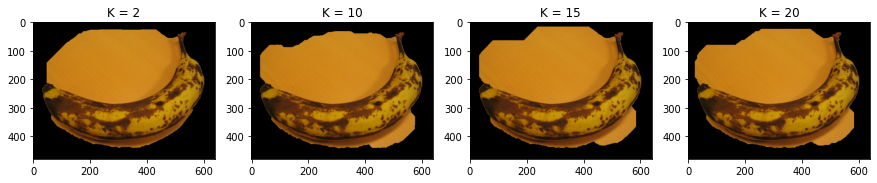

In [16]:
plot_k('b')

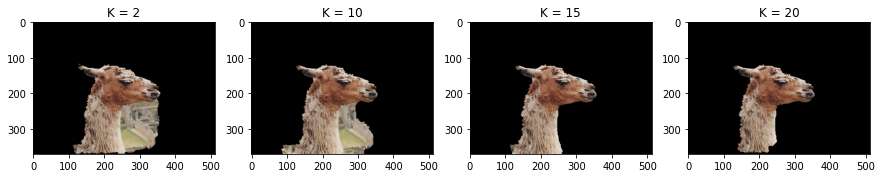

In [18]:
plot_k('l')

## 2) Choice of Gamma 

In [60]:
run('../images/banana1.jpg')
cv2.destroyAllWindows()

Init GMM
Calculating Probablities : 
Construct Graph
Estimate Seg


In [61]:
def plot_gamma(para):
    if para == 'l':
        img1 = cv2.cvtColor( cv2.imread('1_l.jpg') , cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor( cv2.imread('10_l.jpg') , cv2.COLOR_BGR2RGB)
        img3 = cv2.cvtColor( cv2.imread('20_l.jpg') , cv2.COLOR_BGR2RGB)
        img4 = cv2.cvtColor(cv2.imread('30_l.jpg') ,cv2.COLOR_BGR2RGB )
        img5 = cv2.cvtColor(cv2.imread('40_l.jpg') ,cv2.COLOR_BGR2RGB )
        img6 = cv2.cvtColor(cv2.imread('50_l.jpg') ,cv2.COLOR_BGR2RGB )
    else:
        img1 = cv2.cvtColor( cv2.imread('1_b.jpg') , cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor( cv2.imread('10_b.jpg') , cv2.COLOR_BGR2RGB)
        img3 = cv2.cvtColor( cv2.imread('20_b.jpg') , cv2.COLOR_BGR2RGB)
        img4 = cv2.cvtColor(cv2.imread('30_b.jpg') ,cv2.COLOR_BGR2RGB )
        img5 = cv2.cvtColor(cv2.imread('40_b.jpg') ,cv2.COLOR_BGR2RGB )
        img6 = cv2.cvtColor(cv2.imread('50_b.jpg') ,cv2.COLOR_BGR2RGB )
        
    pix , a = plt.subplots(3,2)

    a[0,0].imshow(img1)
    a[0,0].set_title('Gamma = 1')

    a[0,1].imshow(img2)
    a[0,1].set_title('Gamma = 10')
    
    a[1,0].imshow(img3)
    a[1,0].set_title('gamma = 20')
    
    a[1,1].imshow(img4)
    a[1,1].set_title('Gamma = 30')
    
    a[2,0].imshow(img5)
    a[2,0].set_title('Gamma = 40')
    
    a[2,1].imshow(img6)
    a[2,1].set_title('Gamma = 50')
    
    print()

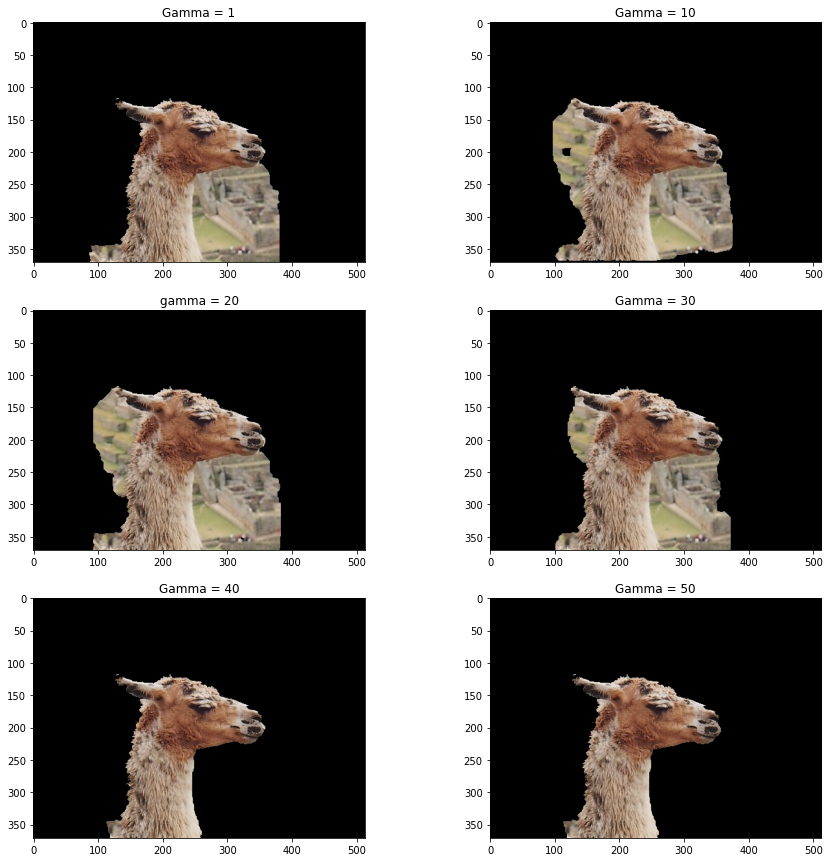

In [49]:
plot_gamma('l')

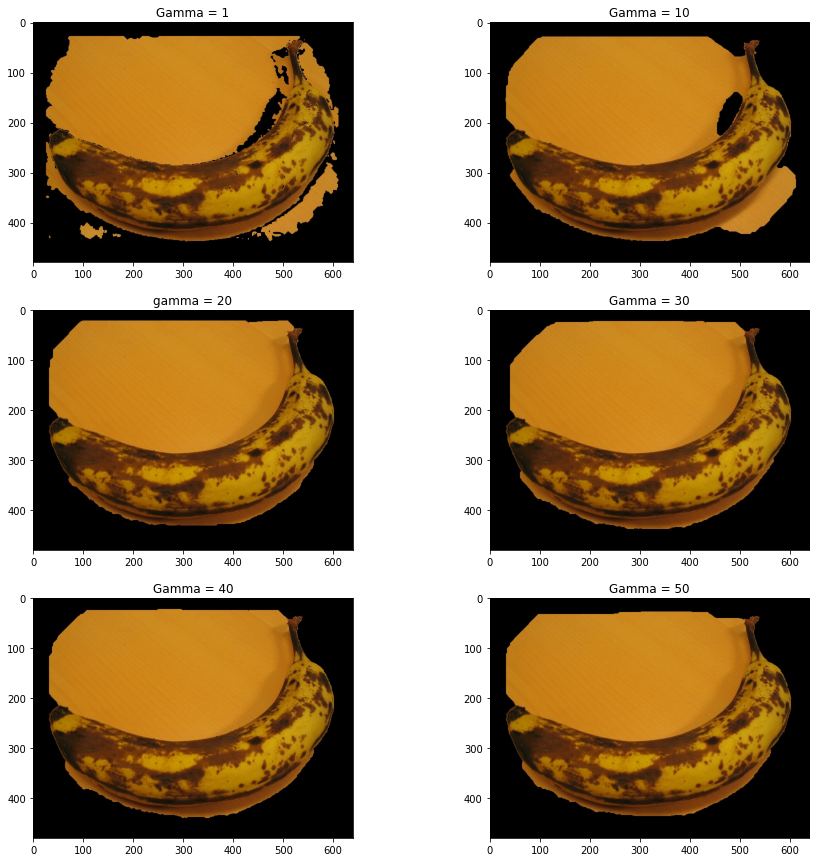

In [63]:
plot_gamma('b')

#### Observations 

1. High Gamma Values results in better segmentation compare to lower gamma values 
2. Also As gamma increses smoothness of segmented edges increses 

## 3) Different Color Space 

#### 1) LAB Color Space 

In [83]:
run('../images/tennis.jpg')
cv2.destroyAllWindows()

Init GMM
Calculating Probablities : 
Construct Graph
Estimate Seg


In [94]:
def plot_k():
    img1 = cv2.cvtColor(cv2.imread('tennis.jpg') , cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread('tennis_hsv.jpg') ,cv2.COLOR_BGR2HSV )
    img3 = cv2.cvtColor(cv2.imread('tennis_lab.jpg') ,cv2.COLOR_BGR2LAB )
    img4 = cv2.cvtColor(cv2.imread('tennis_rgb.jpg') ,cv2.COLOR_BGR2RGB )
    img5 = cv2.cvtColor(cv2.imread('tennis_ycrcb.jpg') ,cv2.COLOR_BGR2YCR_CB )

    pix , a = plt.subplots(1,5)

    a[0].imshow(img1)
    a[0].set_title('Orig')

    a[1].imshow(img2)
    a[1].set_title('HSV')
    
    a[2].imshow(img3)
    a[2].set_title('LAB')
    
    a[3].imshow(img4)
    a[3].set_title('RGB')
    
    a[4].imshow(img5)
    a[4].set_title('Y CR CB')
    
    print()

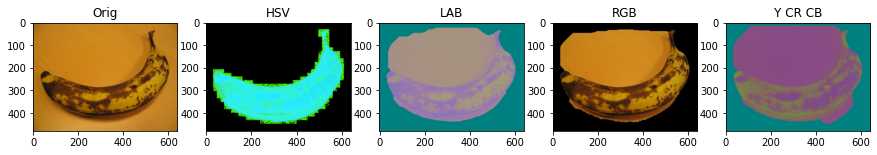

In [88]:
plot_k()

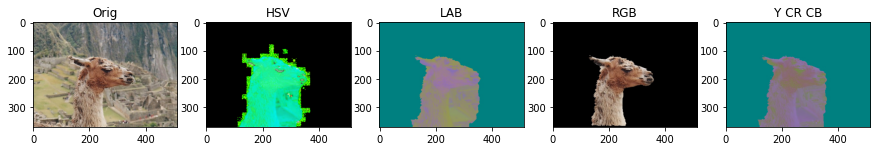

In [90]:
plot_k()

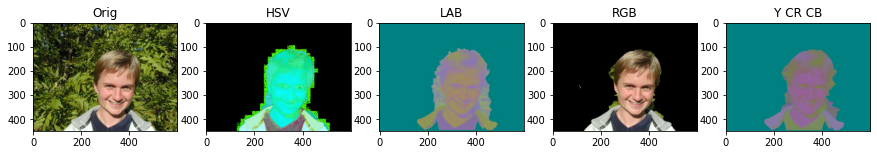

In [93]:
plot_k()

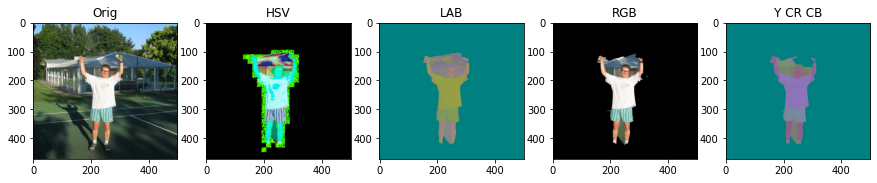

In [95]:
plot_k()

#### Observations 

1. RGB Color Space gives good segmentation among all others 
2. Except in image of Banana HSV Gives best segmentation compare to others with same parameters.

### 4) 4-Neighbourhood  Vs  8-neighbourhood

In [118]:
run('../images/elefant.jpg')
cv2.destroyAllWindows()

Init GMM
Calculating Probablities : 
Construct Graph
Estimate Seg


In [119]:
def plot(img1 ,img2):
    img1 = cv2.cvtColor( cv2.imread(img1) , cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(img2) ,cv2.COLOR_BGR2RGB )

    pix , a = plt.subplots(1,2)

    a[0].imshow(img1)
    a[0].set_title('4 Connected')

    a[1].imshow(img2)
    a[1].set_title('8 Connected')
    print()

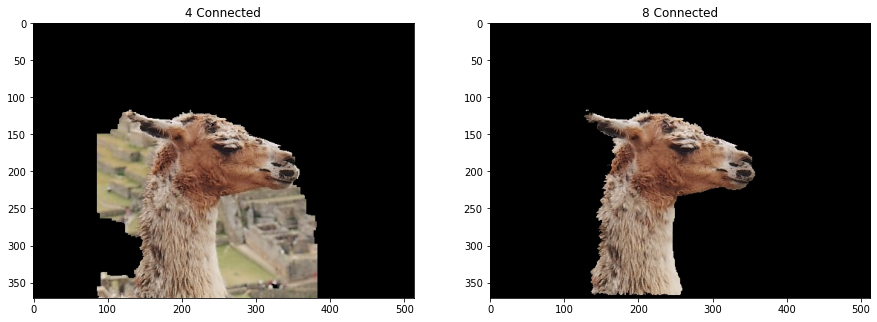

In [120]:
plot('llama4.jpg' ,'llama8.jpg')

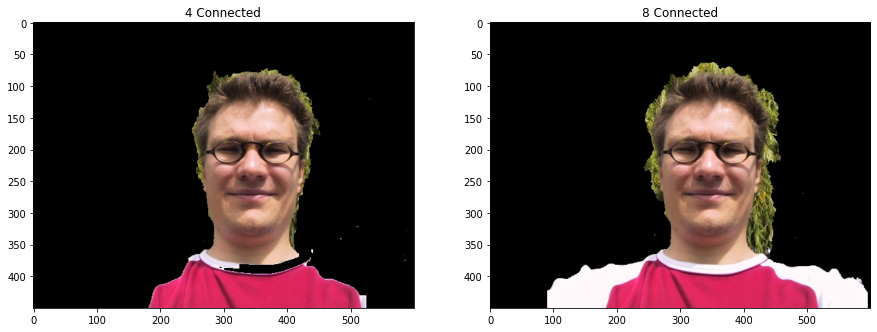

In [124]:
plot('person4.jpg' ,'person8.jpg')

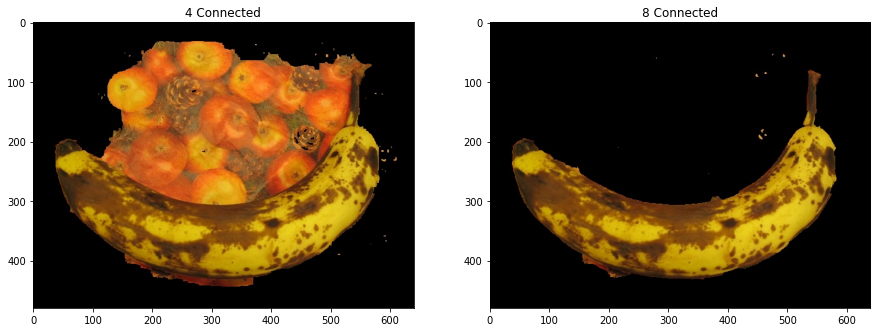

In [122]:
plot('banana4.jpg' ,'banana8.jpg')

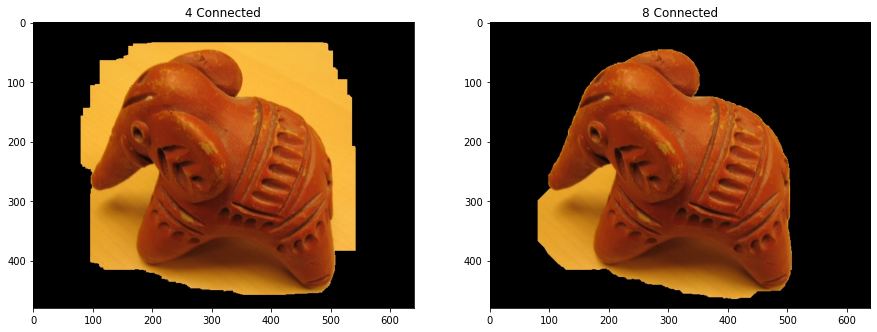

In [123]:
plot('elefant4.jpg' ,'elefant8.jpg')

#### Onservations 

1. 8 Connected scheme gives finer segmentation compare to the 4 connected one 
2. 4 Connected scheme takes more number of iteration to converge 

### 5) Different Ways to set Beta 

1. Median All pairwise Values 
2. Mode 
3. Setting Beta = 0

In [14]:
run('../images/elefant.jpg')
cv2.destroyAllWindows()

Init GMM
Calculating Probablities : 
Construct Graph
Estimate Seg


In [19]:
def plot(img1 ,img2 ,img3 ,img4):
    img1 = cv2.cvtColor( cv2.imread(img1) , cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(img2) ,cv2.COLOR_BGR2RGB )
    img3 = cv2.cvtColor(cv2.imread(img3) ,cv2.COLOR_BGR2RGB )
    img4 = cv2.cvtColor(cv2.imread(img4) ,cv2.COLOR_BGR2RGB )

    pix , a = plt.subplots(1,4)

    a[0].imshow(img1)
    a[0].set_title('Mean Beta')

    a[1].imshow(img2)
    a[1].set_title('Meadian Beta')
    
    
    a[2].imshow(img4)
    a[2].set_title('Mode Beta')
    
    a[3].imshow(img3)
    a[3].set_title('Beta = 0')
    
    print()

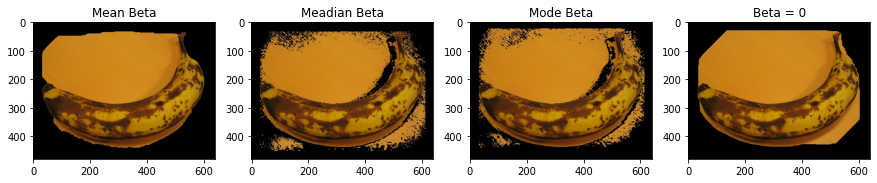

In [20]:
plot('mean_banana1.jpg' ,'med_banana.jpg' ,'0_ban.jpg' ,'mod_banana.jpg')

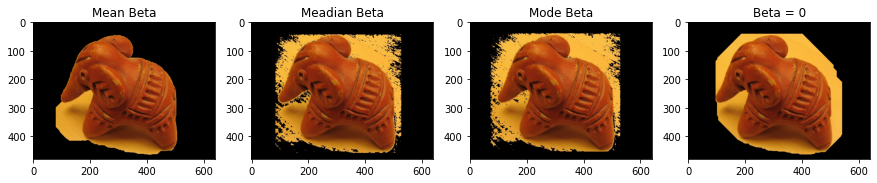

In [21]:
plot('mean_elefant.jpg' ,'med_elefant.jpg' ,'0_ele.jpg' ,'mod_elefant.jpg')

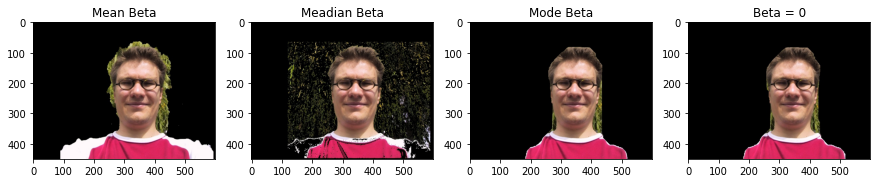

In [22]:
plot('mean_person.jpg' ,'med_person.jpg' ,'0_per.jpg' ,'mod_person.jpg')